In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gmean

import statsmodels.api as sm
from scipy.stats import t, f, boxcox, skew, kurtosis
from statsmodels.stats.diagnostic import linear_reset, het_white


import warnings
warnings.filterwarnings('ignore')

In [137]:
data = pd.read_csv('data_after_processing.csv')

In [138]:
not_null = ['thickness', 'width', 'length', 'volume']
data = data[(data[not_null] > 0).all(axis=1)]

In [139]:
data = data.drop(['title'], axis=1)
data = data.drop(['author_Другой', 'publisher_Другой', 'publication_year_Другой',
                  'cover_type_Мягкий заламинированный картон', 'reading_age_6+'], axis=1)

In [140]:
data.columns

Index(['price', 'avg_rating', 'cnt_reviews', 'pages_cnt', 'tirage', 'weight',
       'author_Джейн Остен', 'author_Джек Лондон', 'author_Джордж Оруэлл',
       'author_Лев Толстой', 'author_Луиза Мэй Олкотт',
       'author_Михаил Булгаков', 'author_Николай Гоголь',
       'author_Федор Достоевский', 'author_Эрих Ремарк', 'publisher_АСТ',
       'publisher_Азбука', 'publisher_Иностранка',
       'publisher_Манн, Иванов и Фербер', 'publisher_Эксмо',
       'publication_year_2021', 'publication_year_2022',
       'publication_year_2023', 'publication_year_2024',
       'publication_year_2025', 'cover_type_Мягкий переплёт',
       'cover_type_Твёрдый переплёт', 'reading_age_0+', 'reading_age_12+',
       'reading_age_16+', 'reading_age_18+', 'thickness', 'width', 'length',
       'volume'],
      dtype='object')

In [141]:
X, y = data.drop(['price'], axis=1), data['price']
X = sm.add_constant(X)
ln_y = np.log(y)

In [142]:
X.shape[0], len(ln_y)

(3256, 3256)

In [143]:
X.columns

Index(['const', 'avg_rating', 'cnt_reviews', 'pages_cnt', 'tirage', 'weight',
       'author_Джейн Остен', 'author_Джек Лондон', 'author_Джордж Оруэлл',
       'author_Лев Толстой', 'author_Луиза Мэй Олкотт',
       'author_Михаил Булгаков', 'author_Николай Гоголь',
       'author_Федор Достоевский', 'author_Эрих Ремарк', 'publisher_АСТ',
       'publisher_Азбука', 'publisher_Иностранка',
       'publisher_Манн, Иванов и Фербер', 'publisher_Эксмо',
       'publication_year_2021', 'publication_year_2022',
       'publication_year_2023', 'publication_year_2024',
       'publication_year_2025', 'cover_type_Мягкий переплёт',
       'cover_type_Твёрдый переплёт', 'reading_age_0+', 'reading_age_12+',
       'reading_age_16+', 'reading_age_18+', 'thickness', 'width', 'length',
       'volume'],
      dtype='object')

In [144]:
num_features = ['avg_rating', 'cnt_reviews', 'pages_cnt', 'tirage', 'weight',
                'thickness', 'width', 'length', 'volume']

## Сравнение функциональных форм на основе теста Бокса-Кокса и PE теста:

**Тест Бокса-Кокса с преобразование Зарембки (адекватный и рабочий)**

In [145]:
geo_mean = gmean(y)
y_help = y/geo_mean
ln_y_help = np.log(y_help)

lin_model = sm.OLS(y_help, X).fit()
rss1 = np.sum(lin_model.resid**2)

semi_log_model = sm.OLS(ln_y_help, X).fit()
rss2 = np.sum(semi_log_model.resid**2)

chi_stat = X.shape[0]/2 * np.abs(np.log(rss1/rss2))
print(f'{chi_stat} > 6.63 значит, между моделями есть существенное различие, выбираем на основе RSS')

859.4058444769837 > 6.63 значит, между моделями есть существенное различие, выбираем на основе RSS


In [146]:
if rss2 < rss1:
  print('Полулогарифмическая модель предпочтительнее')
else:
  print('Линейная модель предпочтительнее')

Полулогарифмическая модель предпочтительнее


**Тест Бокса-Кокса (стремный и нерабочий)**

In [40]:
model = sm.OLS(y, X).fit()
rss1 = np.sum(model.resid**2)

semi_log_model = sm.OLS(ln_y, X).fit()
rss2 = np.sum(semi_log_model.resid**2)

y_boxcox, lambda_optimal = boxcox(y)

print(f"Оптимальное значение λ (метод Бокса-Кокса): {lambda_optimal}")

# Интерпретация
if np.isclose(lambda_optimal, 1, atol=0.1):
    print("Линейная модель (модель 1) предпочтительнее.")
elif np.isclose(lambda_optimal, 0, atol=0.1):
    print("Полулогарифмическая модель (модель 2) предпочтительнее.")
else:
    print("Ни одна из стандартных форм не идеальна, возможно, требуется промежуточная форма.")

Оптимальное значение λ (метод Бокса-Кокса): -0.8034937325907682
Ни одна из стандартных форм не идеальна, возможно, требуется промежуточная форма.


**PE тест**

In [147]:
model_log = sm.OLS(ln_y, X).fit()

yhat_lin = model.fittedvalues
ln_yhat_log = model_log.fittedvalues
yhat_log = np.exp(ln_yhat_log)

mask = yhat_lin >= 0

yhat_lin = yhat_lin[mask]
yhat_log = yhat_log[mask]
ln_y = ln_y[mask]
ln_yhat_log = ln_yhat_log[mask]
X_masked = X[mask]

# Шаг 2: Вспомогательные регрессии
aux_log_X = X_masked.copy()
aux_log_X['delta'] = yhat_lin - yhat_log
aux_log_model = sm.OLS(ln_y, aux_log_X).fit()

aux_lin_X = X_masked.copy()
aux_lin_X['delta'] = ln_yhat_log - np.log(yhat_lin)
aux_lin_model = sm.OLS(y[mask], aux_lin_X).fit()

print("Модель для полулогарифмической спецификации")
print()
print(aux_log_model.summary())

print("Модель для линейной спецификации")
print()
print(aux_lin_model.summary())


Модель для полулогарифмической спецификации

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     433.6
Date:                Sun, 04 May 2025   Prob (F-statistic):               0.00
Time:                        20:06:26   Log-Likelihood:                 371.26
No. Observations:                3252   AIC:                            -670.5
Df Residuals:                    3216   BIC:                            -451.4
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

**Вывод:** все значимо, нужны другие функциональные формы

## Сравнение функциональных форм на основе нормированной R^2:

In [148]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     540.9
Date:                Sun, 04 May 2025   Prob (F-statistic):               0.00
Time:                        20:06:36   Log-Likelihood:                -20729.
No. Observations:                3256   AIC:                         4.153e+04
Df Residuals:                    3221   BIC:                         4.174e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                             278.3915    172.117      1.617      0.106     -59.077     615.861
avg_rating                         21.0623      7.361      2.861      0.004       6.629      35.495
cnt_reviews                         0.1583      0.024      6.640      0.000       0.112       0.205
pages_cnt                          -0.4624      0.026    -17.828      0.000      -0.513      -0.412
tirage                             -0.0120      0.001    -11.032      0.000      -0.014      -0.010
weight                              1.7730      0.030     59.917      0.000       1.715       1.831
author_Джейн Остен                 -6.7501     17.521     -0.385      0.700     -41.103      27.603
author_Джек Лондон                -22.0679     17.147     -1.287      0.198     -55.688      11.552
author_Джордж Оруэлл               11.1018     18.134      0.612      0.540     -24.453      46.656
author_Лев Толстой                -85.2406     19.273     -4.423      0.000    -123.029     -47.452
author_Луиза Мэй Олкотт           -17.0134     20.160     -0.844      0.399     -56.541      22.514
author_Михаил Булгаков             67.2283     16.583      4.054      0.000      34.715      99.742
author_Николай Гоголь             -38.5154     20.439     -1.884      0.060     -78.589       1.559
author_Федор Достоевский          -50.5112     13.043     -3.873      0.000     -76.084     -24.938
author_Эрих Ремарк                 49.5413     18.182      2.725      0.006      13.892      85.190
publisher_АСТ                     -89.1631     18.627     -4.787      0.000    -125.685     -52.641
publisher_Азбука                 -120.8672     19.369     -6.240      0.000    -158.844     -82.890
publisher_Иностранка             -150.0874     22.045     -6.808      0.000    -193.311    -106.864
publisher_Манн, Иванов и Фербер   -93.2753     24.846     -3.754      0.000    -141.992     -44.559
publisher_Эксмо                  -111.5480     18.859     -5.915      0.000    -148.525     -74.571
publication_year_2021              -2.3139     28.014     -0.083      0.934     -57.242      52.614
publication_year_2022               8.1149     23.409      0.347      0.729     -37.783      54.013
publication_year_2023              24.5463     22.502      1.091      0.275     -19.574      68.666
publication_year_2024              32.1704     22.122      1.454      0.146     -11.204      75.545
publication_year_2025              32.6362     22.300      1.463      0.143     -11.088      76.360
cover_type_Мягкий переплёт        -31.5068    141.820     -0.222      0.824    -309.574     246.561
cover_type_Твёрдый переплёт       -45.0098    141.750     -0.318      0.751    -322.940     232.920
reading_age_0+                   -143.5689     88.424     -1.624      0.105    -316

In [149]:
ln_X = np.log(data[num_features])
ln_X = pd.concat([ln_X, X.drop(columns=num_features)], axis=1)
ln_X = sm.add_constant(ln_X)

model_ln_X = sm.OLS(y, ln_X).fit()

In [150]:
model_ln_X.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     251.1
Date:                Sun, 04 May 2025   Prob (F-statistic):               0.00
Time:                        20:06:39   Log-Likelihood:                -21756.
No. Observations:                3256   AIC:                         4.358e+04
Df Residuals:                    3222   BIC:                         4.379e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
avg_rating                         89.7436     49.336      1.819      0.069      -6.990     186.478
cnt_reviews                        13.7996      3.077      4.484      0.000       7.766      19.833
pages_cnt                        -321.2715     18.825    -17.066      0.000    -358.181    -284.362
tirage                            -84.9547      7.907    -10.744      0.000    -100.459     -69.451
weight                            717.8490     17.604     40.778      0.000     683.333     752.365
thickness                         -63.6595     20.762     -3.066      0.002    -104.367     -22.952
width                              94.4715     26.354      3.585      0.000      42.800     146.143
length                             43.6833     37.006      1.180      0.238     -28.873     116.240
volume                             74.4954     14.031      5.309      0.000      46.985     102.006
const                           -1738.4644    275.435     -6.312      0.000   -2278.510   -1198.418
author_Джейн Остен                -10.2398     24.044     -0.426      0.670     -57.382      36.903
author_Джек Лондон                -36.1602     23.519     -1.537      0.124     -82.275       9.954
author_Джордж Оруэлл               21.3754     24.843      0.860      0.390     -27.335      70.086
author_Лев Толстой                -61.2088     26.298     -2.327      0.020    -112.772      -9.646
author_Луиза Мэй Олкотт           -20.5420     27.651     -0.743      0.458     -74.757      33.673
author_Михаил Булгаков             87.2910     22.732      3.840      0.000      42.720     131.862
author_Николай Гоголь             -24.1705     28.019     -0.863      0.388     -79.108      30.767
author_Федор Достоевский          -42.9782     17.914     -2.399      0.016     -78.103      -7.853
author_Эрих Ремарк                 33.0632     24.960      1.325      0.185     -15.876      82.002
publisher_АСТ                     -57.7059     25.490     -2.264      0.024    -107.684      -7.728
publisher_Азбука                   -0.6769     26.406     -0.026      0.980     -52.452      51.098
publisher_Иностранка               79.2501     29.877      2.653      0.008      20.670     137.830
publisher_Манн, Иванов и Фербер   -81.4442     33.898     -2.403      0.016    -147.908     -14.980
publisher_Эксмо                   -70.0747     25.736     -2.723      0.007    -120.536     -19.614
publication_year_2021             -52.2297     38.371     -1.361      0.174    -127.463      23.003
publication_year_2022             -83.4072     32.037     -2.603      0.009    -146.222     -20.592
publication_year_2023             -66.2700     30.789     -2.152      0.031    -126.639      -5.901
publication_year_2024             -51.9486     30.227     -1.719      0.086    -111

**Вывод:** при сравнении ln_X - y с X - y нормированный R^2 лучше у X - y

In [151]:
ln_X.shape[0], len(ln_y)

(3256, 3252)

In [152]:
model_ln_X_ln_y = sm.OLS(ln_y, ln_X).fit()
model_ln_X_ln_y.summary()

ValueError: The indices for endog and exog are not aligned

In [153]:
model_ln_y = sm.OLS(ln_y, X).fit()
model_ln_y.summary()

ValueError: The indices for endog and exog are not aligned

**Вывод:** незначительно лучше ln_y - X, чем ln_y - ln_X

## Еще одно подтверждение этому:

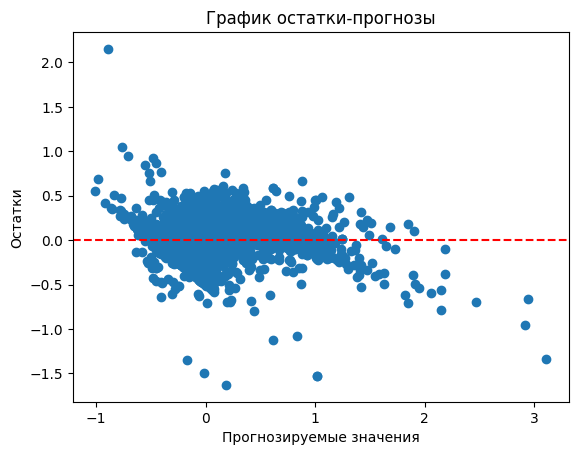

In [154]:
# Визуальный анализ
residuals_ln_y = semi_log_model.resid
fitted_values_ln_y = semi_log_model.fittedvalues

plt.scatter(fitted_values_ln_y, residuals_ln_y)
plt.axhline(0, color='red', linestyle='--')  # Прямая "остатки = 0"
plt.xlabel('Прогнозируемые значения')
plt.ylabel('Остатки')
plt.title('График остатки-прогнозы')
plt.show()

**Тест Рамсея**
<br>
Посмотрим на то, квадраты каких переменных стоит включать

In [156]:
reset_result = linear_reset(model, power=2)

print("RESET test (Ramsey)")
print(reset_result)

RESET test (Ramsey)
<Wald test (chi2): statistic=57.296244584653955, p-value=3.748703346023147e-14, df_denom=1>


**Вывод:** тест Рамсея показывает, что добавление степеней в модель помогает лучше описать данные

Проверим необходимость в квадратах тех признаков, которые сильнее всего влияют на себестоимость

In [157]:
X_ramsey = X.copy()
X_ramsey["weight ** 2"] = X_ramsey["weight"]**2
model_for_ramsey = sm.OLS(y, X_ramsey).fit()

RSS_with = sum(model_for_ramsey.resid**2)
RSS_without = sum(model.resid**2)

k_reduced = X.shape[1]
k_full = X_ramsey.shape[1]

df1, df2 = k_full - k_reduced, len(y) - k_full

F_stat = ((RSS_without - RSS_with) / df1) / (RSS_with / df2)
p_value = 1 - f.cdf(F_stat, df1, df2)

print(f"F-статистика: {F_stat}")
print(f"p-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Отвергаем H0: Переменная weight^2 значима и улучшает модель.")
else:
    print("Не отвергаем H0: Переменная weight^2 незначима и может быть исключена.")

F-статистика: 0.9732069707708837
p-value: 0.32395579015186704
Не отвергаем H0: Переменная weight^2 незначима и может быть исключена.


In [158]:
X_ramsey = X.copy()
X_ramsey["pages_cnt ** 2"] = X_ramsey["pages_cnt"]**2
model_for_ramsey = sm.OLS(y, X_ramsey).fit()

RSS_with = sum(model_for_ramsey.resid**2)
RSS_without = sum(model.resid**2)

k_reduced = X.shape[1]
k_full = X_ramsey.shape[1]

df1, df2 = k_full - k_reduced, len(y) - k_full

F_stat = ((RSS_without - RSS_with) / df1) / (RSS_with / df2)
p_value = 1 - f.cdf(F_stat, df1, df2)

print(f"F-статистика: {F_stat}")
print(f"p-value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Отвергаем H0: Переменная pages_cnt^2 значима и улучшает модель.")
else:
    print("Не отвергаем H0: Переменная pages_cnt^2 незначима и может быть исключена.")

F-статистика: 48.41131925730164
p-value: 4.168554390560075e-12
Отвергаем H0: Переменная pages_cnt^2 значима и улучшает модель.


**Включение неважной переменной** (F-test)

**Тесты на гетероскедастичности**

In [ ]:
residuals = model.resid

In [ ]:
# Тест Уайта
white_test = het_white(residuals, X)

lm_stat, lm_pval, f_stat, f_pval = white_test

print(f"LM-статистика: {lm_stat}")
print(f"p-value для LM-статистики: {lm_pval}")
print(f"F-статистика: {f_stat}")
print(f"p-value для F-статистики: {f_pval}")

if lm_pval < 0.05:
    print("Гетероскедастичность выявлена.")
else:
    print("Нет признаков гетероскедастичности.")

In [ ]:
# Тест Уайта
white_test = het_white(residuals_ln_y, X)

lm_stat, lm_pval, f_stat, f_pval = white_test

print(f"LM-статистика: {lm_stat}")
print(f"p-value для LM-статистики: {lm_pval}")
print(f"F-статистика: {f_stat}")
print(f"p-value для F-статистики: {f_pval}")

if lm_pval < 0.05:
    print("Гетероскедастичность выявлена.")
else:
    print("Нет признаков гетероскедастичности.")

In [ ]:
# Тест Глейзера
abs_residuals = np.abs(residuals)
glejser_model = sm.OLS(abs_residuals, X).fit()

p_values = glejser_model.pvalues
# print(f"P-значения:")
# if p_values[0]:
#     print(p_values)
if any(p < 0.05 for p in p_values[1:]):
    print("Есть признаки гетероскедастичности.")
else:
    print("Нет признаков гетероскедастичности.")


In [ ]:
# Тест Глейзера
abs_residuals = np.abs(residuals_ln_y)
glejser_model = sm.OLS(abs_residuals, X).fit()

p_values = glejser_model.pvalues
# print(f"P-значения:")
# if p_values[0]:
#     print(p_values)
if any(p < 0.05 for p in p_values[1:]):
    print("Есть признаки гетероскедастичности.")
else:
    print("Нет признаков гетероскедастичности.")


**Гипотеза о незначимости**

**Тест Чоу**